## Binance top 200 coins by volume and momentum

In [11]:
coins = 3

## 1- Obtengo la data usando la API de Binance

In [12]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_top_volume_coins_list_api(count=200):
    # Obtener la lista de todos los símbolos de trading
    symbols_url = "https://api.binance.com/api/v3/exchangeInfo"
    symbols_response = requests.get(symbols_url)
    symbols_data = symbols_response.json()
    
    # Filtrar solo los pares con USDT
    usdt_symbols = [symbol['symbol'] for symbol in symbols_data['symbols'] if symbol['symbol'].endswith('USDT')]

    # Elimino las stablecoins
    stablecoins = ['USDCUSDT', 'FDUSDUSDT', '1000SATS', '1000SATSBTC']
    usdt_symbols = [symbol for symbol in usdt_symbols if symbol not in stablecoins]
    
    # Calcular la fecha de inicio (7 días atrás)
    start_time = int((datetime.now() - timedelta(days=7)).timestamp() * 1000)
    
    # Obtener el volumen para cada símbolo
    volumes = []
    for symbol in usdt_symbols:
        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_time}"
        klines_response = requests.get(klines_url)
        klines_data = klines_response.json()
        
        # Calcular el volumen promedio
        total_volume = sum(float(kline[7]) for kline in klines_data) #7 es quote asset volume
        avg_volume = total_volume / len(klines_data) if klines_data else 0
        volumes.append((symbol[:-4], avg_volume))  # Removemos 'USDT' del símbolo
    
    # Ordenar por volumen descendente y tomar los primeros 'count'
    top_volumes = sorted(volumes, key=lambda x: x[1], reverse=True)[:count]
    
    return top_volumes  # Ahora retornamos la lista completa de tuplas (moneda, volumen)

def get_top_volume_coins_df_api(count=200):
    volumes = get_top_volume_coins_list_api(count)
    df = pd.DataFrame(volumes, columns=['coin', 'average volume last 7 days'])

    # Ordenar el DataFrame antes de formatear los números
    df = df.sort_values('average volume last 7 days', ascending=False)

   # Formatear los números después de ordenar
    df['average volume last 7 days'] = df['average volume last 7 days'].apply(lambda x: f'{x:.2f}')

    return df

In [13]:
api_top_coins_list = get_top_volume_coins_list_api(coins)
#api_top_coins_list

In [14]:
api_top_coins_df = get_top_volume_coins_df_api(coins)
api_top_coins_df

,coin,average volume last 7 days
0,BTC,1414461436.62
1,ETH,625476195.48
2,SOL,350411424.58


#### Conclusion
Mejor uso el API directamente, ya que evito que CS50 tenga que instalar un paquete adicional de python. 

Las variables que pasan a la siguiente etapa son: 


api_top_coins_df 

api_top_coins_list

Trabajare con la lista pero primero tengo que eliminar los valores de volumen, que hago a continuacion

In [15]:
# Get the ticker list for coins.
top_coins = [item[0] for item in api_top_coins_list]
top_coins

['BTC', 'ETH', 'SOL']

## 2- Obtener klines para cada criptomoeda

#### USANDO EL WRAPER

In [25]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT
# FUNCION QUE USA EL WRAPER
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta, timezone
import os


client = Client()

not_available_btcpair = []
# FUNCION PARA BTC PAIRS
def get_klines_btcpair_wraper(crypto_list, weeks_back: int):
    """    
    weeks_back: int -> Indica la cantidad de semanas atras a considerar. 0 para esta semana, 1 para la semana anterior, etc.
    """
    today = datetime.now(timezone.utc)  # Asegurarse de trabajar en UTC
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())

    # Obtener la fecha del lunes de la semana objetivo y convertir a 00:00 en UTC
    target_monday = monday_this_week - timedelta(weeks=weeks_back)
    target_monday_at_midnight = target_monday.replace(hour=0, minute=0, second=0, microsecond=0)

    # Obtener la fecha del domingo de la semana objetivo y convertir a 00:00 en UTC
    target_sunday = target_monday + timedelta(days=6)
    target_sunday_at_midnight = target_sunday.replace(hour=0, minute=0, second=0, microsecond=0)    

    # Retornar como timestamp en UTC en str
    start_timestamp = str(target_monday_at_midnight.timestamp())
    print(f"Start timestamp: {start_timestamp}")

    end_timestamp = str(target_sunday_at_midnight.timestamp())
    print(f"End timestamp: {end_timestamp}")


    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data'):
        os.makedirs('data')

    for crypto in crypto_list:
        try:
            print(f"Fetching data for {crypto}BTC...")
            klines = client.get_historical_klines(
                symbol=f"{crypto}BTC", # for BTC pairs
                #symbol=f"{crypto}USDT", # for USDT pairs
                interval=Client.KLINE_INTERVAL_1DAY,
                start_str=start_timestamp,
                end_str=end_timestamp,
            )
            print (klines)

            # Crear el DataFrame
            df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Guardar el DataFrame como CSV
            filename = f"data/{crypto}BTC.csv"
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto} guardados en {filename}")

        except Exception as e:
            print(f"Error al obtener datos para {crypto}BTC.")
            print(e)
            not_available_btcpair.append(crypto)
            continue

    return dataframes

#ejemplo de uso
#dataframes = get_klines_btcpair_wraper(top_coins, 1)

#### USANDO LA API PELADA

In [51]:
# Obtiene klines con la lista top_coins, el par BTC y el par USDT
# FUNCION QUE USA EL WRAPER
import pandas as pd
from binance.client import Client
from datetime import datetime, timedelta, timezone
import os


client = Client()

not_available_btcpair = []
# FUNCION PARA BTC PAIRS
def get_klines_btcpair(crypto_list, weeks_back: int):
    """    
    weeks_back: int -> Indica la cantidad de semanas atras a considerar. 0 para esta semana, 1 para la semana anterior, etc.
    """
    today = datetime.now(timezone.utc)  # Asegurarse de trabajar en UTC
    
    # Calcular el lunes de la semana actual
    monday_this_week = today - timedelta(days=today.weekday())

    # Obtener la fecha del lunes de la semana objetivo y convertir a 00:00 en UTC
    target_monday = monday_this_week - timedelta(weeks=weeks_back)
    target_monday_at_midnight = target_monday.replace(hour=0, minute=0, second=0, microsecond=0)

    # Obtener la fecha del domingo de la semana objetivo y convertir a 00:00 en UTC
    target_sunday = target_monday + timedelta(days=6)
    target_sunday_at_midnight = target_sunday.replace(hour=0, minute=0, second=0, microsecond=0)    

    # Retornar como timestamp en UTC en str
    start_timestamp = str(int(target_monday_at_midnight.timestamp()))
    #print(f"Start timestamp: {start_timestamp}")

    end_timestamp = str(int(target_sunday_at_midnight.timestamp()))
    #print(f"End timestamp: {end_timestamp}")


    dataframes = []

    # Crear la carpeta 'data' si no existe
    if not os.path.exists('data'):
        os.makedirs('data')

    for crypto in crypto_list:
        
        print(f"Fetching data for {crypto}BTC...")
        symbol=f"{crypto}BTC" # for BTC pairs
        start_str=start_timestamp+'000'
        #print(start_str)
        end_str=end_timestamp+'000'

        klines_url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval=1d&startTime={start_str}&endTime={end_str}"
        print(klines_url)
        klines_response = requests.get(klines_url)
        print(klines_response.status_code)

        if klines_response.status_code == 200:
            print('se obtuvo codigo 200')
            klines_data = klines_response.json()
            print (klines_data)

            # Crear el DataFrame
            df = pd.DataFrame(klines_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
            
            # Convertir el timestamp a datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            
            # Establecer el timestamp como índice
            df.set_index('timestamp', inplace=True)
            
            # Convertir las columnas necesarias a float
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df[col] = df[col].astype(float)
            
            # Eliminar las columnas que no me sirve
            df = df.drop(['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], axis=1)

            # Guardar el DataFrame como CSV
            filename = f"data/{crypto}BTC.csv"
            print(filename)
            df.to_csv(filename)
            
            dataframes.append(df)
            print(f"Datos de {crypto} guardados en {filename}")
            print ('-----------------------------------------')
        
        elif klines_response.status_code == 404:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            print(klines_response.text)
            not_available_btcpair.append(crypto)
            print ('-----------------------------------------')

        elif klines_response.status_code == 400:
            print(f"Error: {crypto}BTC no está disponible en Binance.")
            not_available_btcpair.append(crypto)
            print ('-----------------------------------------')

    return dataframes

#ejemplo de uso
dataframes = get_klines_btcpair(top_coins, 1)

Fetching data for BTCBTC...
https://api.binance.com/api/v3/klines?symbol=BTCBTC&interval=1d&startTime=1725235200000&endTime=1725753600000
400
Error: BTCBTC no está disponible en Binance.
-----------------------------------------
Fetching data for ETHBTC...
https://api.binance.com/api/v3/klines?symbol=ETHBTC&interval=1d&startTime=1725235200000&endTime=1725753600000
200
se obtuvo codigo 200
[[1725235200000, '0.04235000', '0.04340000', '0.04231000', '0.04291000', '21882.97790000', 1725321599999, '938.33287600', 126684, '10502.47060000', '450.14745664', '0'], [1725321600000, '0.04291000', '0.04294000', '0.04204000', '0.04218000', '15037.32130000', 1725407999999, '637.86831894', 83161, '6880.11890000', '291.78855646', '0'], [1725408000000, '0.04219000', '0.04274000', '0.04128000', '0.04226000', '31515.78410000', 1725494399999, '1325.99422403', 142479, '16301.87140000', '686.11354707', '0'], [1725494400000, '0.04226000', '0.04245000', '0.04181000', '0.04216000', '17020.48260000', 17255807999

In [52]:
not_available_btcpair

['BTC']

## 3. Data Processing

In [53]:
# Limpiamos el df con solo las columnas que nos interesan

dataframes[0]

,open,high,low,close,volume
timestamp,,,,,
2024-09-02,0.04235,0.04340,0.04231,0.04291,21882.9779
2024-09-03,0.04291,0.04294,0.04204,0.04218,15037.3213
2024-09-04,0.04219,0.04274,0.04128,0.04226,31515.7841
2024-09-05,0.04226,0.04245,0.04181,0.04216,17020.4826
2024-09-06,0.04217,0.04258,0.04085,0.04123,46145.7447
2024-09-07,0.04124,0.04227,0.04123,0.04199,20385.5488
2024-09-08,0.04198,0.04229,0.04175,0.04186,18918.6580


In [56]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def analyze_crypto_data(data_folder='data'):
    results = []
    
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            coin = filename.split('.')[0]
            filepath = os.path.join(data_folder, filename)
            
            # Leer el archivo CSV
            df = pd.read_csv(filepath)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            
            # Calcular el retorno
            first_open = df.iloc[0]['open']
            last_close = df.iloc[-1]['close']
            returns = (last_close - first_open) / first_open * 100
            
            # Preparar datos para la regresión lineal
            X = np.arange(len(df)).reshape(-1, 1)
            y = df['close'].values
            
            # Realizar regresión lineal
            model = LinearRegression()
            model.fit(X, y)
            
            intercept = model.intercept_
            slope = model.coef_[0]
            
            results.append({
                'coin': coin,
                'return': returns,
                'intercept': intercept,
                'slope': slope
            })
    
    # Crear DataFrame con los resultados
    result_df = pd.DataFrame(results)
    
    # Ordenar por slope de mayor a menor
    result_df = result_df.sort_values('slope', ascending=False)
    
    return result_df

# Ejemplo de uso
df_maestro = analyze_crypto_data()
df_maestro

,coin,return,intercept,slope
1,SOLBTC,5.711101,0.002248,0.000020
0,ETHBTC,-1.157025,0.042573,-0.000163


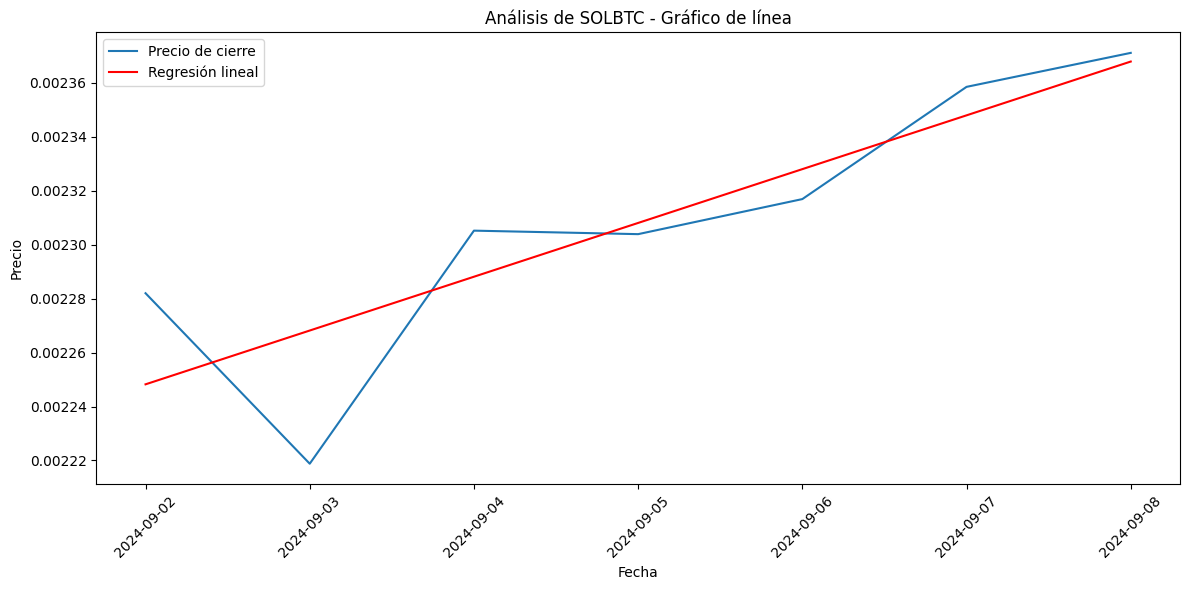

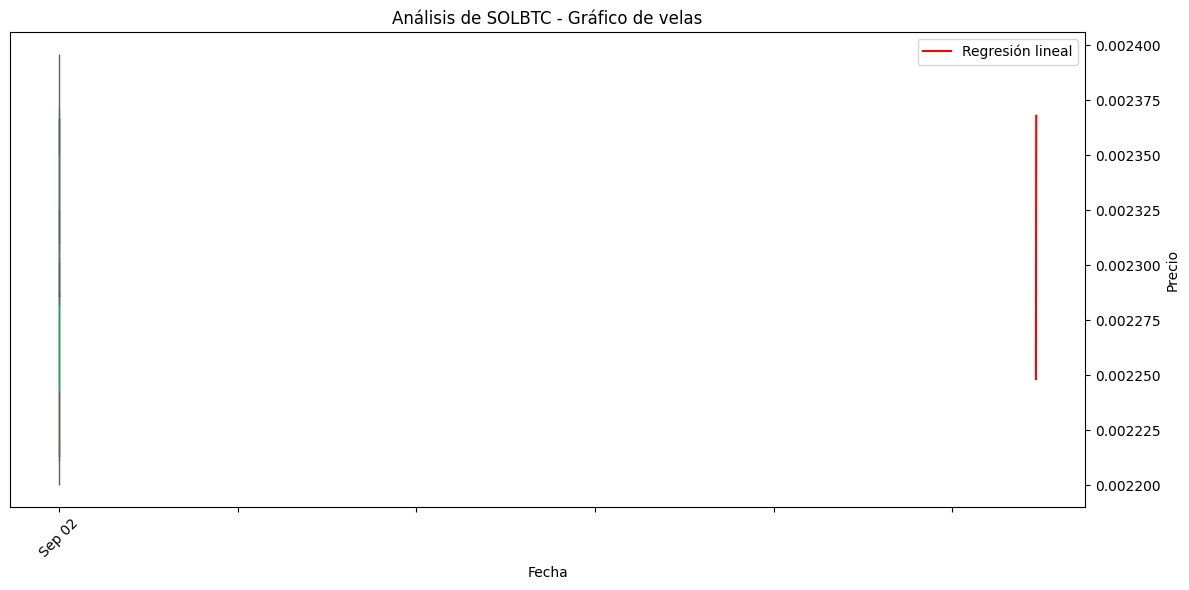

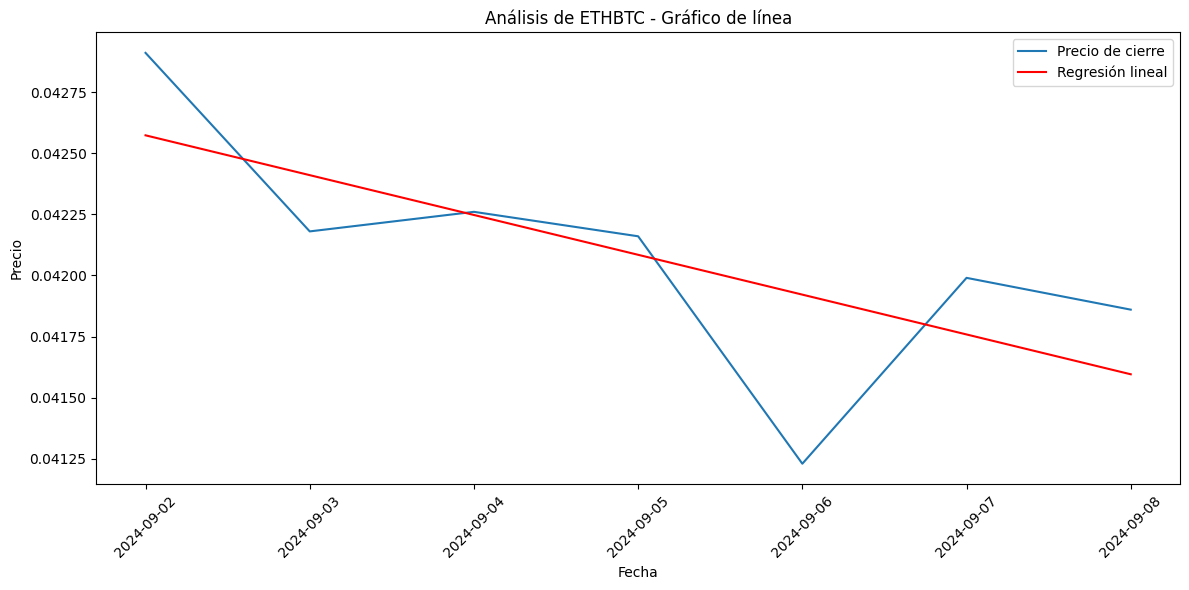

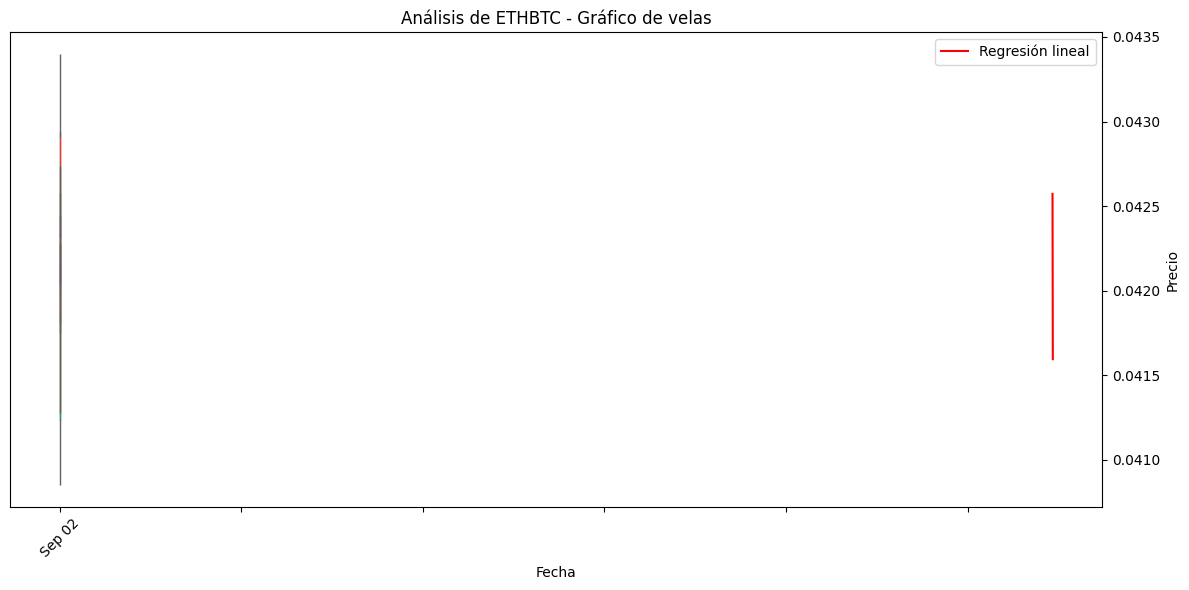

In [57]:
# Ploteo 1 

import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_crypto_data(df_maestro, data_folder='data', plot_folder='plots'):
    # Crear la carpeta 'plots' si no existe
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)

    for _, row in df_maestro.iterrows():
        coin = row['coin']
        slope = row['slope']
        intercept = row['intercept']

        # Leer el archivo CSV correspondiente
        df = pd.read_csv(os.path.join(data_folder, f"{coin}.csv"))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

        # Calcular la línea de regresión
        x = range(len(df))
        regression_line = [slope * xi + intercept for xi in x]

        # Gráfico de línea
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['close'], label='Precio de cierre')
        plt.plot(df.index, regression_line, label='Regresión lineal', color='red')
        plt.title(f"Análisis de {coin} - Gráfico de línea")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_line.png"))
        plt.show()

        # Gráfico de velas (candlestick)
        fig, ax = plt.subplots(figsize=(12, 6))
        mpf.plot(df, type='candle', style='yahoo', ax=ax)
        ax.plot(df.index, regression_line, label='Regresión lineal', color='red')
        ax.set_title(f"Análisis de {coin} - Gráfico de velas")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Precio")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_candlestick.png"))
        plt.show()

# Ejemplo de uso:
df_maestro = analyze_crypto_data()  # Asumiendo que esta función ya fue definida y ejecutada
plot_crypto_data(df_maestro)

In [59]:
# Ploteo 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_crypto_data(df_maestro, data_folder='data', plot_folder='plots'):
    # Crear la carpeta 'plots' si no existe
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)

    for _, row in df_maestro.iterrows():
        coin = row['coin']
        slope = row['slope']
        intercept = row['intercept']

        # Leer el archivo CSV correspondiente
        df = pd.read_csv(os.path.join(data_folder, f"{coin}.csv"))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)

        # Calcular la línea de regresión
        x = range(len(df))
        regression_line = [slope * xi + intercept for xi in x]

        # Gráfico de línea
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['close'], label='Precio de cierre')
        plt.plot(df.index, regression_line, label='Regresión lineal', color='red')
        plt.title(f"Análisis de {coin} - Gráfico de línea")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_folder, f"{coin}_line.png"))
        plt.close()

        # Gráfico de velas (candlestick)
        mpf.plot(df, type='candle', style='yahoo', title=f"Análisis de {coin} - Gráfico de velas",
                 ylabel='Precio', ylabel_lower='Volumen',
                 volume=True, figsize=(12, 6),
                 savefig=os.path.join(plot_folder, f"{coin}_candlestick.png"))
        
        # Agregar la línea de regresión al gráfico de velas
        fig, axes = mpf.plot(df, type='candle', style='yahoo', title=f"Análisis de {coin} - Gráfico de velas",
                             ylabel='Precio', ylabel_lower='Volumen',
                             volume=True, figsize=(12, 6),
                             returnfig=True)
        axes[0].plot(df.index, regression_line, color='red', label='Regresión lineal')
        axes[0].legend(['Regresión lineal'])
        plt.savefig(os.path.join(plot_folder, f"{coin}_candlestick_with_regression.png"))
        plt.close()

# Ejemplo de uso:
df_maestro = analyze_crypto_data()  # Asumiendo que esta función ya fue definida y ejecutada
plot_crypto_data(df_maestro)